In [1]:
import numpy as np
import gym
import random
from IPython.display import clear_output
import time
from matplotlib import pyplot as plt
from matplotlib import patches as patches
from tqdm.notebook import tqdm

# Creating the environment

In [42]:
# Making the environment
# [X] reset() -> generate random environment and return a state
# [X] random_step() -> performs a random action and returns the next_state,reward,done
# [X] step(action) -> performs the given action and returns the next_state,reward,done

class GridEnv:
    
    def __init__(self,rows=None,cols=None,block_prob=0.1,grid=[]):
        if len(grid) > 0:
            self.grid = np.array(grid)
            self.rows = len(self.grid)
            self.cols = len(self.grid[0,:])
            self.block_prob = None
        else:
            self.rows = rows
            self.cols = cols
            self.block_prob = block_prob
        
        self.observation_space = np.empty((0))
        for i in range(self.rows * self.cols):
            self.observation_space = np.append(self.observation_space, i)
        
        # Top = 0
        # Bottom = 1
        # Left = 2
        # Right = 3
        self.action_space = [0,1,2,3]
        self.dx = [-1,0,1,0]
        self.dy = [0,1,0,-1]
        
        self.uturn = 0
        self.turn = 0
        self.length = 0
        self.penalty = 0
        self.c_x = []
        self.c_y = []
    
    def random_step(self):
        return random.choice(self.action_space)
    
    def reset(self):
        if self.block_prob != None:
            self._generate_random_grid()
        self.state = 0
        self.posX = 0
        self.posY = 0
        self.prevAction = None
        self.done = False
        self.uturn = 0
        self.turn = 0
        self.length = 0
        self.penalty = 0
        return self.state
    
    def step(self,action):
        reward = 0
        uturn_penalty = -3
        turn_penalty = -3
        length_penalty = -2
        done = False
        if action == 0:
            # if it is over top bounds
            if self.posX + 1 == self.rows:
                reward = -10
                self.penalty += 1
            # if there is a blocked cell
            elif self.grid[self.posX + 1,self.posY] == 1:
                reward = -10
                self.penalty += 1
            # check for u-turn
            elif self.prevAction == 1:
                reward = uturn_penalty
                self.posX += 1
                self.state = self.posX * self.rows + self.posY
                self.uturn += 1
            # check for turns
            elif self.prevAction == 2 or self.prevAction == 3:
                reward = turn_penalty
                self.posX += 1
                self.state = self.posX * self.rows + self.posY
                self.turn += 1
            else:
                self.posX += 1
                self.state = self.posX * self.rows + self.posY
                reward = length_penalty
        elif action == 1:
            # if it is below bottom bounds
            if self.posX - 1 == -1:
                reward = -10
                self.penalty += 1
            # if there is a blocked cell
            elif self.grid[self.posX - 1,self.posY] == 1:
                reward = -10
                self.penalty += 1
            # check for u-turn
            elif self.prevAction == 0:
                reward = uturn_penalty
                self.posX -= 1
                self.state = self.posX * self.rows + self.posY
                self.uturn += 1
            # check for turns
            elif self.prevAction == 2 or self.prevAction == 3:
                reward = turn_penalty
                self.posX -= 1
                self.turn += 1
                self.state = self.posX * self.rows + self.posY
            else:
                self.posX -= 1
                self.state = self.posX * self.rows + self.posY
                reward = length_penalty
        elif action == 2:
            # if it is left of left bounds
            if self.posY - 1 == -1:
                reward = -10
                self.penalty += 1
            # if there is a blocked cell
            elif self.grid[self.posX,self.posY - 1] == 1:
                reward = -10
                self.penalty += 1
            # check for u-turn
            elif self.prevAction == 3:
                reward = uturn_penalty
                self.posY -= 1
                self.uturn += 1
                self.state = self.posX * self.rows + self.posY
            # check for turns
            elif self.prevAction == 0 or self.prevAction == 1:
                reward = turn_penalty
                self.posY -= 1
                self.turn += 1
                self.state = self.posX * self.rows + self.posY
            else:
                self.posY -= 1
                self.state = self.posX * self.rows + self.posY
                reward = length_penalty
        else:
            # if it is right of right bounds
            if self.posY + 1 == self.cols:
                reward = -10
                self.penalty += 1
            # if there is a blocked cell
            elif self.grid[self.posX,self.posY + 1] == 1:
                reward = -10
                self.penalty += 1
            # check for u-turn
            elif self.prevAction == 2:
                reward = uturn_penalty
                self.uturn += 1
                self.posY += 1
                self.state = self.posX * self.rows + self.posY
            # check for turns
            elif self.prevAction == 0 or self.prevAction == 1:
                reward = turn_penalty
                self.posY += 1
                self.turn += 1
                self.state = self.posX * self.rows + self.posY
            else:
                self.posY += 1
                self.state = self.posX * self.rows + self.posY
                reward = length_penalty
                
        if self.state == (self.rows * self.cols - 1):
            done = True
            
        if reward != -10:
            self.prevAction = action
            self.length += 1
        return self.state, reward, done
        
    def dfs(self,pos,visited):
        if pos[0] == self.rows-1 and pos[1] == self.cols-1:
            return True
        visited[pos[0],pos[1]] = 1
        found = False
        for x,y in zip(self.dx,self.dy):
            newX = pos[0] + x
            newY = pos[1] + y
            if newX < 0 or newX == self.rows or newY < 0 or newY == self.cols:
                continue
            elif self.grid[newX,newY] == 1:
                continue
            elif visited[newX,newY] == 0:
                found |= self.dfs((newX,newY),visited)
                if found:
                    return True
        return found
        
    def restart(self):
        self.posX = 0
        self.posY = 0
        self.state = 0
        self.prevAction = None
        self.done = False
        self.uturn = 0
        self.turn = 0
        self.length = 0
        self.penalty = 0
        return self.state
        
    def _generate_random_grid(self):
        done = False
        while not done:
            self.grid = np.zeros((self.rows,self.cols))
            for i in range(self.rows):
                for j in range(self.cols):
                    if random.random() < self.block_prob:
                        self.grid[i,j] = 1
            self.grid[0,0] = 0
            self.grid[self.rows-1,self.cols-1] = 0
            
            # DFS
            visited = np.zeros((self.rows,self.cols))
            start = (0,0)
            done = self.dfs(start,visited)
    
    def _generate_figure(self):
        x = 5.0
        y = 5.0
        a = 10.0
        for i in range(0,self.rows):
            for j in range(0,self.cols):
                if self.grid[i,j] == 0:
                    plt.gca().add_patch(patches.Rectangle((x, y),a,a,fill = False))
                    self.c_x.append(x+5.0)
                    self.c_y.append(y+5.0)
                else:
                    plt.gca().add_patch(patches.Rectangle((x, y),a,a))
                    self.c_x.append(x+5.0)
                    self.c_y.append(y+5.0)
                x = x + 10.0
            y = y - 10.0
            x = x - (j+1)*10.0
    
    def plot(self,best):
        self._generate_figure()
        path_x = []
        path_y = []
        for k in range(0,len(best)):
            path_x.append(self.c_x[best[k]])
            path_y.append(self.c_y[best[k]])
            
        for i in range(0,len(self.c_x)):
            if i in best:
                plt.scatter(self.c_x[i],self.c_y[i],c = "black")
        plt.plot(path_x,path_y,'k')
    
    def render(self):
        for i in range(self.rows):
            print(':',end='')
            for j in range(self.cols):
                if self.posX == i and self.posY == j:
                    print('#',end=':')
                elif (i == 0 and j == 0) or (i == self.rows-1 and j == self.cols-1):
                    print('$',end=':')
                elif self.grid[i,j] == 1:
                    print('0',end=':')
                else:
                    print(' ',end=':')
            print()
            if i != self.rows-1:
                print(' ',end='')
                for j in range(self.cols):
                    print('-',end=' ')
                print()

# Initializing the environment

In [43]:
env = GridEnv(rows=10,cols=10,block_prob=0.2)
state = env.reset()
env.render()

:#: :0: : : : : : :0:
 - - - - - - - - - - 
: : : : : :0: : :0:0:
 - - - - - - - - - - 
:0: : : :0: : : : :0:
 - - - - - - - - - - 
: : : : : : : :0:0: :
 - - - - - - - - - - 
: : : :0: : :0:0: : :
 - - - - - - - - - - 
: : : : : : : : : :0:
 - - - - - - - - - - 
: : : : : : : : :0: :
 - - - - - - - - - - 
:0: : : : : : : : : :
 - - - - - - - - - - 
: :0:0: : : : : : : :
 - - - - - - - - - - 
: : : :0: : : : : :$:


# Declaring environment parameters

In [68]:
# learning rate similar to supervised learning
alpha = 0.15
# parameter on how much to emphasize future gains
gamma = 0.75
# parameter to control exploitation/exploration
epsilon = 0.001

num_steps = 25000

q_table = np.zeros((len(env.observation_space), len(env.action_space)))

# Training

In [69]:
penalty_list = []
path_length_list = []
turn_list = []
uturn_list = []

for i in tqdm(range(num_steps)):
    state = env.restart()
    done = False
    while not done:
        # Choose best possible action
        # Used epsilon to introduce exploration
        if random.random() < epsilon:
            action = env.random_step()
        else:
            action = np.argmax(q_table[state, :])
        
        # action = np.argmax(q_table[state, :])
        
        # Do the action
        next_state, reward, done = env.step(action)

        # Update q-table
        new_q_value = (1-alpha)*q_table[state, action] + \
            alpha*(reward + gamma*np.max(q_table[next_state, :]))

        # Assign new values and go the next state
        q_table[state, action] = new_q_value
        state = next_state
        epsilon -= 0.00000001
    
    penalty_list.append(env.penalty)
    turn_list.append(env.turn)
    uturn_list.append(env.uturn)
    path_length_list.append(env.length)
        
print("Training finished")

  0%|          | 0/25000 [00:00<?, ?it/s]

Training finished


# Visualizing the best path

Total penalty => 0
Steps => 18
Turns => 3
U-turns => 0


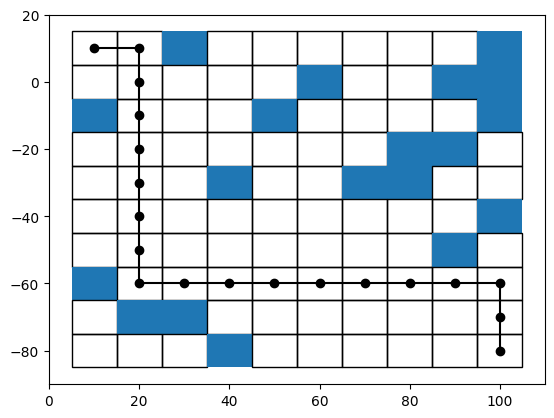

In [70]:
done = False
state = env.restart()
best = []

while not done:
    # clear_output(wait=True)
    # time.sleep(0.5)
    
    best.append(state)
    action = np.argmax(q_table[state,:])
    next_state,reward,done = env.step(action)
    
    state = next_state
    # env.render()
    
best.append(state)
env.plot(best)
print(f"Total penalty => {env.penalty}\nSteps => {env.length}\nTurns => {env.turn}\nU-turns => {env.uturn}")

# Plots and analytics

## Total penalty

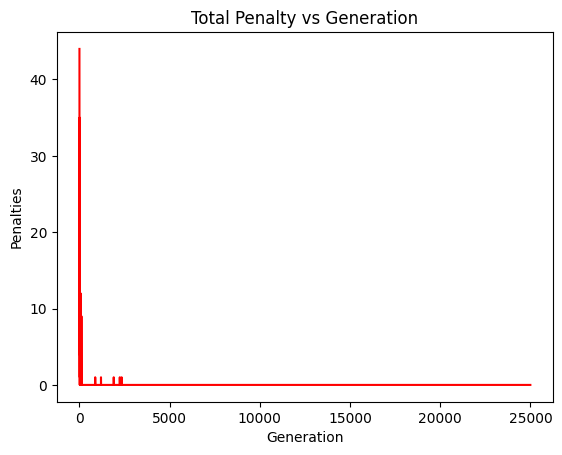

In [71]:
from matplotlib import pyplot as plt

plt.plot(penalty_list,color="red")
plt.title("Total Penalty vs Generation")
plt.xlabel("Generation")
plt.ylabel("Penalties")
plt.show()

## Number of Turns

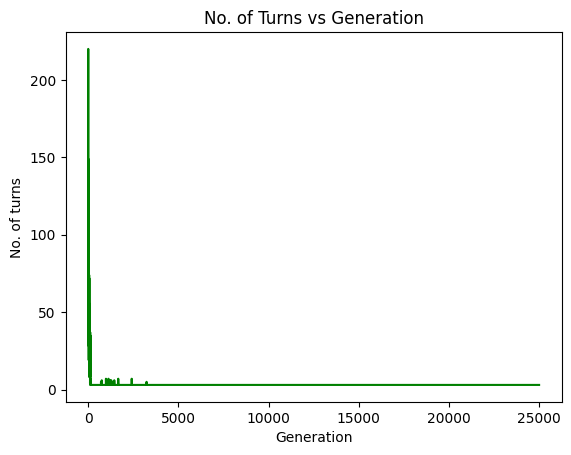

In [72]:
from matplotlib import pyplot as plt

plt.plot(turn_list,color="green")
plt.title("No. of Turns vs Generation")
plt.xlabel("Generation")
plt.ylabel("No. of turns")
plt.show()

## Number of U-Turns

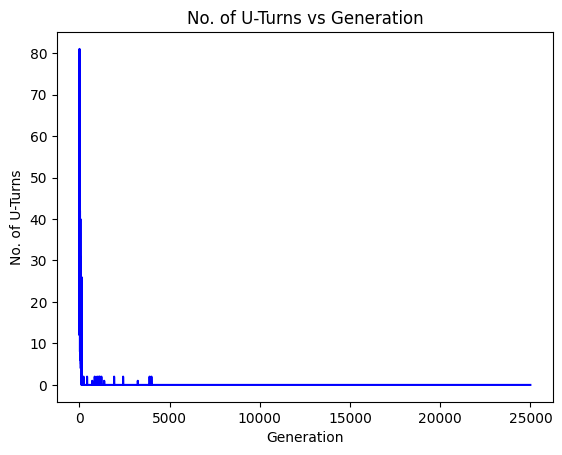

In [73]:
from matplotlib import pyplot as plt

plt.plot(uturn_list,color="blue")
plt.title("No. of U-Turns vs Generation")
plt.xlabel("Generation")
plt.ylabel("No. of U-Turns")
plt.show()

## Path length

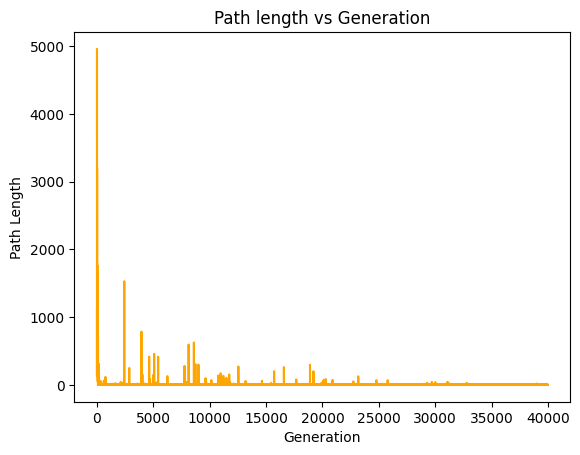

In [25]:
from matplotlib import pyplot as plt

plt.plot(uturn_list,color="orange")
plt.title("Path length vs Generation")
plt.xlabel("Generation")
plt.ylabel("Path Length")
plt.show()

# Using custom environment

In [36]:
obs = [304,305,306,307,308,309,310,311,312,313,314,315,365,415,465,515,565,615,
       665,715,765,815,865,915,965,1015,1065,1064,1063,1062,1061,1060,1059,1058,
       1057,1056,1055,1054,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,
       1014,354,355,356,357,358,359,360,361,362,363,364,414,464,514,564,614,
       664,714,764,814,864,914,964,954,955,956,957,958,959,960,961,962,963,404,
       405,406,407,408,409,410,411,412,413,463,513,563,613,663,713,763,813,863,
       913,963,1404,1405,1406,1407,1408,1409,1410,1411,1412,1413,1414,1415,1465,
       1515,1565,1615,1665,1715,1765,1815,1865,1915,1965,2015,2065,2115,2165,
       2164,2163,2162,2161,2160,2159,2158,2157,2156,2155,2154,1454,1455,1456,
       1457,1458,1459,1460,1461,1462,1463,1464,1514,1564,1614,1664,1714,1764,
       1814,1864,1914,1964,2014,2064,2114,2113,2112,2111,2110,2109,2108,2107,
       2106,2105,2104,2054,2055,2056,2057,2058,2059,2060,2061,2062,2063,1504,
       1505,1506,1507,1508,1509,1510,1511,1512,1513,1563,1613,1663,1713,1763,
       1813,1863,1913,1963,2013,2063,2062,2061,2060,2059,2058,2057,2056,2055,
       2054,333,334,335,336,337,338,339,340,341,342,343,344,345,383,384,385,386,387,
       388,389,390,391,392,393,394,395,433,434,435,436,437,438,439,440,441,442,
       443,444,445,483,484,485,533,534,535,583,584,585,633,634,635,683,684,685,
       733,734,735,783,784,785,833,834,835,883,884,885,933,934,935,983,984,985,
       986,987,988,989,990,991,992,993,994,995,1033,1034,1035,1036,1037,1038,
       1039,1040,1041,1042,1043,1044,1045,1083,1084,1085,1086,1087,1088,1089,
       1090,1091,1092,1093,1094,1095,1433,1434,1435,1436,1437,1438,1439,1440,
       1441,1442,1443,1444,1445,1483,1484,1485,1486,1487,1488,1489,1490,1491,
       1492,1493,1494,1495,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542,
       1543,1544,1545,1583,1584,1585,1633,1634,1635,1683,1684,1685,1733,1734,
       1735,1783,1784,1785,1833,1834,1835,1883,1884,1885,1933,1934,1935,1983,
       1984,1985,2033,2034,2035,2083,2084,2085,2086,2087,2088,2089,2090,2091,
       2092,2093,2094,2095,2133,2134,2135,2136,2137,2138,2139,2140,2141,2142,
       2143,2144,2145,2183,2184,2185,2186,2187,2188,2189,2190,2191,2192,2193,
       2194,2195]

ROWS = 50
COLS = 50
obstacle_matrix = np.zeros((ROWS,COLS))

for index in obs:
    r = index//ROWS
    c = index%ROWS
    obstacle_matrix[r,c] = 1

# Declare environment with obstacle matrix

In [37]:
env = GridEnv(grid=obstacle_matrix)
state = env.reset()